## Introduction

##### $\rightarrow$ Provide a brief introduction to the purpose of this notebook.

Here we will focus on average student performance on the ACT or SAT exams that students take as part of the college application process. Is school performance predicted by socioeconomic factors?

## Import libraries and Data

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style='whitegrid')

# Import additional libraries

# Train-test splits
from sklearn.model_selection import train_test_split

# Model preprocessing
from sklearn.preprocessing import StandardScaler

# Imputation
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, IterativeImputer, KNNImputer

In [ ]:
df = pd.read_csv('https://raw.githubusercontent.com/danielmrios/Methodologies-of-Data-Science/main/Education-Inequality/education_df.csv')

## Prep Data for Extra Step

As part of my extra step, I chose to further explore socioeconmic variables not previously considered:
- Percentage of residents foreign born
- Percentage of residents who speak a different language than english at home

The data was retrieved from the United States Census Bureau. It can be accessed here: https://data.census.gov/advanced


In [ ]:
extra_df = pd.read_csv('ACSDP5Y2017.DP02-Data.csv', header=1)

<ipython-input-543-9c48d1c70431>:1: DtypeWarning: Columns (173,245) have mixed types. Specify dtype option on import or set low_memory=False.
  extra_df = pd.read_csv('ACSDP5Y2017.DP02-Data.csv', header=1)


In [ ]:
extra_df = extra_df.iloc[1:]

# Reset the index after dropping the first row
extra_df = extra_df.reset_index(drop=True)

##### $\rightarrow$ Look at data types

In [ ]:
extra_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33119 entries, 0 to 33118
Columns: 611 entries, Geography to Unnamed: 610
dtypes: float64(309), object(302)
memory usage: 154.4+ MB


Convert zip code to string

In [ ]:
# Convert zip_code column to string, extract the last 5 characters, and then convert back to integer
# extra_df['Geographic Area Name'] = extra_df['Geographic Area Name'].astype(str)

Convert variables to float 64

In [ ]:

extra_df['Percent Estimate!!PLACE OF BIRTH!!Total population!!Foreign born'] = pd.to_numeric(extra_df['Percent Estimate!!PLACE OF BIRTH!!Total population!!Foreign born'], errors='coerce')
extra_df['Percent Estimate!!LANGUAGE SPOKEN AT HOME!!Population 5 years and over!!Language other than English'] = pd.to_numeric(extra_df['Percent Estimate!!LANGUAGE SPOKEN AT HOME!!Population 5 years and over!!Language other than English'], errors='coerce')

In [ ]:
extra_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33119 entries, 0 to 33118
Columns: 611 entries, Geography to Unnamed: 610
dtypes: float64(311), object(300)
memory usage: 154.4+ MB


##### $\rightarrow$ Tidy data

Filter the DataFrame to keep only the desired columns

In [ ]:
columns = [
    "Geographic Area Name",
    "Percent Estimate!!PLACE OF BIRTH!!Total population!!Foreign born",
    "Percent Estimate!!LANGUAGE SPOKEN AT HOME!!Population 5 years and over!!Language other than English"
]

extra_df = extra_df[columns]

print(extra_df.head())

  Geographic Area Name  \
0          ZCTA5 00602   
1          ZCTA5 00603   
2          ZCTA5 00606   
3          ZCTA5 00610   
4          ZCTA5 00612   

   Percent Estimate!!PLACE OF BIRTH!!Total population!!Foreign born  \
0                                                NaN                  
1                                                NaN                  
2                                                NaN                  
3                                                NaN                  
4                                                NaN                  

   Percent Estimate!!LANGUAGE SPOKEN AT HOME!!Population 5 years and over!!Language other than English  
0                                                NaN                                                    
1                                                NaN                                                    
2                                                NaN                                                 

Modify the Geographic Area Name column to extract the ZIP's

In [ ]:
extra_df['Geographic Area Name'] = extra_df['Geographic Area Name'].astype(str).str[-5:].astype(int)

Tidy up column names

In [ ]:
def clean_column_name(column_name):
    return column_name.lower().replace(' ', '_')

extra_df.columns = [clean_column_name(col) for col in extra_df.columns]

Modify columns to remove '!!'

In [ ]:
def extract_column_name(column_name):
    return column_name.split('!!')[-1]

extra_df.columns = [extract_column_name(col) for col in extra_df.columns]

extra_df.columns = ['zip_code' if col == 'geographic_area_name' else col for col in extra_df.columns]

print(extra_df.head())

   zip_code  foreign_born  language_other_than_english
0       602           NaN                          NaN
1       603           NaN                          NaN
2       606           NaN                          NaN
3       610           NaN                          NaN
4       612           NaN                          NaN


##### $\rightarrow$ Data Cleaning

Convert columns to a percentage

In [ ]:
extra_df['foreign_born'] = extra_df['foreign_born'] / 100
extra_df['language_other_than_english'] = extra_df['language_other_than_english'] / 100

print(extra_df[['foreign_born', 'language_other_than_english']])

       foreign_born  language_other_than_english
0               NaN                          NaN
1               NaN                          NaN
2               NaN                          NaN
3               NaN                          NaN
4               NaN                          NaN
...             ...                          ...
33114           NaN                          NaN
33115         0.009                        0.059
33116         0.026                        0.060
33117         0.000                        0.000
33118         0.044                        0.056

[33119 rows x 2 columns]


In [ ]:
nan_counts = extra_df.isna().sum()

print(nan_counts)

zip_code                         0
foreign_born                   445
language_other_than_english    445
dtype: int64


Looks like there are records which may have no entry's for some of the variables. We also observed this in the df head.

Lets remove records which have NaN values in 4+ columns (non ZIP columns)

In [ ]:
extra_df = extra_df.dropna(thresh=len(extra_df.columns) - 3)

nan_counts = extra_df.isna().sum()

print(nan_counts)

zip_code                         0
foreign_born                   445
language_other_than_english    445
dtype: int64


Later in Imputation I ran into an issue where some values were '-' rather than NaN, I'll fix this on the original df before train/test

In [ ]:
# identify rows with string values ('-') in numeric columns
rows_with_strings = df.apply(lambda row: any(isinstance(val, str) and val == '-' for val in row), axis=1)

# return the rows containing string values
rows_with_strings_data = df[rows_with_strings]

df = df.replace('-', np.nan)

##### $\rightarrow$ Join with the clean df

In [ ]:
df.shape

(7204, 12)

Join the df's

In [ ]:
df = df.merge(extra_df, how='left', on='zip_code')

print(df.head())

             id  rate_unemployment  percent_college  percent_married  \
0  100001600143           0.117962         0.445283         0.346495   
1  100008000024           0.063984         0.662765         0.767619   
2  100008000225           0.056460         0.701864         0.713090   
3  100017000029           0.044739         0.692062         0.641283   
4  100018000040           0.077014         0.640060         0.834402   

   median_income  average_act  percent_lunch       year state  zip_code  \
0        42820.0    20.433455       0.066901  2016-2017    DE     19804   
1        89320.0    19.498168       0.112412  2016-2017    DE     19709   
2        84140.0    19.554335       0.096816  2016-2017    DE     19709   
3        56500.0    17.737485       0.296960  2016-2017    DE     19958   
4        54015.0    18.245421       0.262641  2016-2017    DE     19934   

      school_type school_level  foreign_born  language_other_than_english  
0  Regular School         High         0

In [ ]:
df.shape

(7204, 14)

##### $\rightarrow$ Train/Test Split

In [ ]:
X = df.drop(columns=['average_act'])

# Extract the target variable from the DataFrame
y = df['average_act']

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(5763, 13)
(5763,)
(1441, 13)
(1441,)


##### $\rightarrow$ Imputation

In [ ]:
nan_counts_train = X_train.isna().sum()
nan_counts_test = X_test.isna().sum()

print(nan_counts_train)
print(nan_counts_test)

id                              0
rate_unemployment               9
percent_college                 9
percent_married                15
median_income                  11
percent_lunch                   0
year                            0
state                           0
zip_code                        0
school_type                     0
school_level                    0
foreign_born                   49
language_other_than_english    49
dtype: int64
id                              0
rate_unemployment               3
percent_college                 2
percent_married                 3
median_income                   3
percent_lunch                   0
year                            0
state                           0
zip_code                        0
school_type                     0
school_level                    0
foreign_born                   13
language_other_than_english    13
dtype: int64


In [ ]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

# Define the numeric variables for imputation
num_vars = ['rate_unemployment', 'percent_college', 'percent_married', 'median_income', 'foreign_born', 'language_other_than_english']

imputer = IterativeImputer()

# Fit the imputer on the training data and transform it
X_train[num_vars] = imputer.fit_transform(X_train[num_vars])

# Transform the testing data using the fitted imputer
X_test[num_vars] = imputer.transform(X_test[num_vars])

print(X_train.shape)
print(X_test.shape)

X_train shape after imputation: (5763, 13)
X_test shape after imputation: (1441, 13)


In [ ]:
nan_counts_train = X_train.isna().sum()
nan_counts_test = X_test.isna().sum()

print(nan_counts_train)
print(nan_counts_test)

id                             0
rate_unemployment              0
percent_college                0
percent_married                0
median_income                  0
percent_lunch                  0
year                           0
state                          0
zip_code                       0
school_type                    0
school_level                   0
foreign_born                   0
language_other_than_english    0
dtype: int64
id                             0
rate_unemployment              0
percent_college                0
percent_married                0
median_income                  0
percent_lunch                  0
year                           0
state                          0
zip_code                       0
school_type                    0
school_level                   0
foreign_born                   0
language_other_than_english    0
dtype: int64


Looks good

##### $\rightarrow$ Review the contents of the updated data set.

In [ ]:
df.head()

,id,rate_unemployment,percent_college,percent_married,median_income,average_act,percent_lunch,year,state,zip_code,school_type,school_level,foreign_born,language_other_than_english
0,100001600143,0.117962,0.445283,0.346495,42820.0,20.433455,0.066901,2016-2017,DE,19804,Regular School,High,0.118,0.170
1,100008000024,0.063984,0.662765,0.767619,89320.0,19.498168,0.112412,2016-2017,DE,19709,Regular School,High,0.052,0.084
2,100008000225,0.056460,0.701864,0.713090,84140.0,19.554335,0.096816,2016-2017,DE,19709,Regular School,High,0.052,0.084
3,100017000029,0.044739,0.692062,0.641283,56500.0,17.737485,0.296960,2016-2017,DE,19958,Regular School,High,0.056,0.066
4,100018000040,0.077014,0.640060,0.834402,54015.0,18.245421,0.262641,2016-2017,DE,19934,Regular School,High,0.045,0.093


## State your questions

The overall problem is to determine whether and how average school ACT performance is related to socioeconomic factors. To answer this general problem, you will need to ask specific questions about the data.


##### $\rightarrow$ Our Questions
- Can we use socioeconomic variables to reasonably predict ACT score?
- Which variables are the strongest predictors? The weakest?
- Does there exist a correlation between ACT score and language spoken at home, foreign born population?

## Analysis

We previously derived that the socioeconomic variables *seem* to be useful for predicting ACT score using a pariplot. But It'd be helpful to do a bit more of an exploration on which ones specifically are correlated and what that looks like.

##### $\rightarrow$ Let's start by splitting the schools into quartiles by ACT score and see what the average socieconomic status (for numeric variables) looks like in each bucket. This could be interesting to see how it changes across groups past a best fit line.

In [ ]:
import pandas as pd

# define the list of variables
variables = ['rate_unemployment', 'percent_college', 'percent_married',
             'median_income', 'average_act', 'percent_lunch', 'foreign_born', 'language_other_than_english']

# split the DataFrame into quartiles
quartiles = pd.qcut(df['average_act'], q=4, labels=False)

# create a new DataFrame to store the results
quartile_summary = pd.DataFrame(columns=['Quartile'] + variables)

# calculate the average of each variable for each quartile
for i in range(4):
    quartile_data = df[quartiles == i]
    row_data = {'Quartile': f'Quartile {i+1}'}
    for variable in variables:
        row_data[variable] = quartile_data[variable].mean()
    quartile_summary = pd.concat([quartile_summary, pd.DataFrame(row_data, index=[0])], ignore_index=True)

quartile_summary.head()

,Quartile,rate_unemployment,percent_college,percent_married,median_income,average_act,percent_lunch,foreign_born,language_other_than_english
0,Quartile 1,0.133178,0.491969,0.513536,40748.087004,17.012246,0.683502,0.146394,0.251504
1,Quartile 2,0.097040,0.535145,0.642675,47688.289312,19.709126,0.425905,0.075590,0.132975
2,Quartile 3,0.083026,0.571927,0.682111,53025.863450,21.269542,0.319956,0.058633,0.101557
3,Quartile 4,0.070344,0.705519,0.730083,71375.793167,23.438826,0.198073,0.096591,0.136172


Plotting it

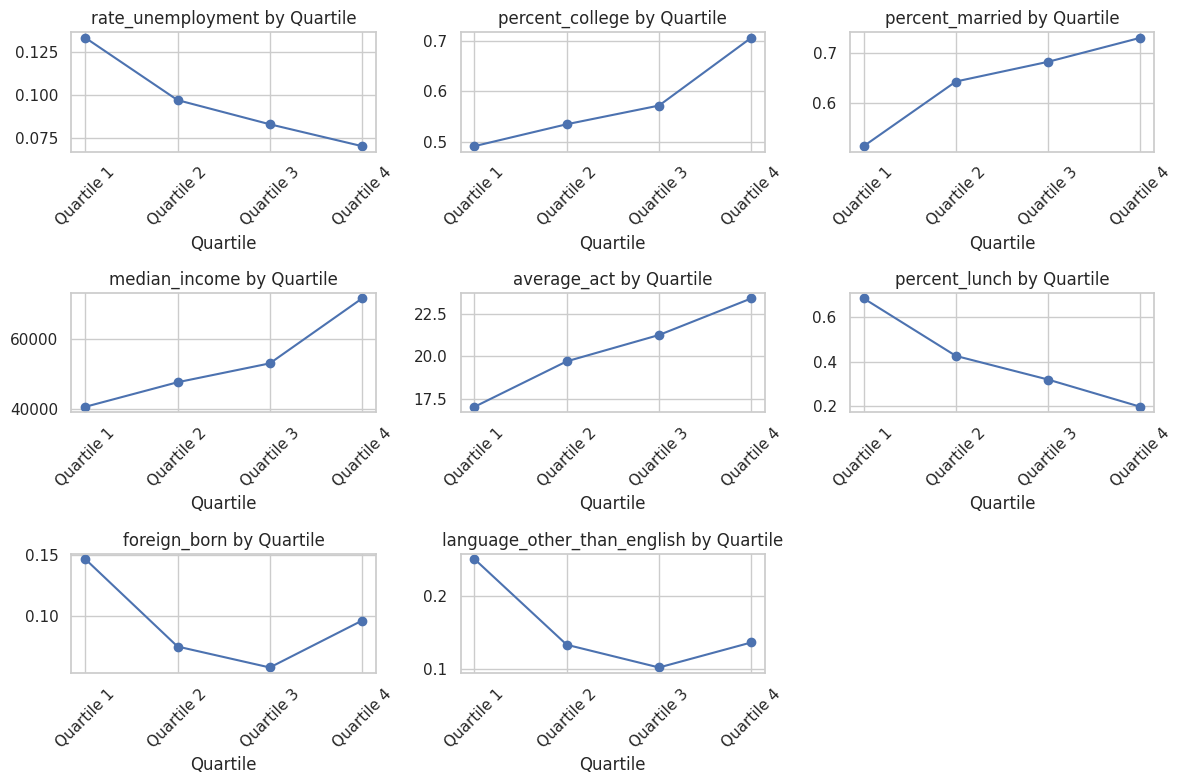

In [ ]:
features = ['rate_unemployment', 'percent_college', 'percent_married', 'median_income', 'average_act', 'percent_lunch', 'foreign_born', 'language_other_than_english']

num_cols = 3
num_rows = (len(features) - 1) // num_cols + 1

# plotting
fig, axs = plt.subplots(num_rows, num_cols, figsize=(12, 8))
axs = axs.flatten()

for i, feature in enumerate(features):
    axs[i].plot(quartile_summary['Quartile'], quartile_summary[feature], marker='o', linestyle='-')
    axs[i].set_xlabel('Quartile')
    axs[i].set_title(f'{feature} by Quartile')
    axs[i].grid(True)
    axs[i].tick_params(axis='x', rotation=45)

for j in range(len(features), num_cols * num_rows):
    fig.delaxes(axs[j])

plt.tight_layout()
plt.show()

We can clearly see most if not all features have correlation accross ACT score.

This gives us a good start, the socieconomic features do seem to be good predictors of how the school will perform on the ACT.

##### $\rightarrow$ Making a pairplot colored by our ACT quartiles

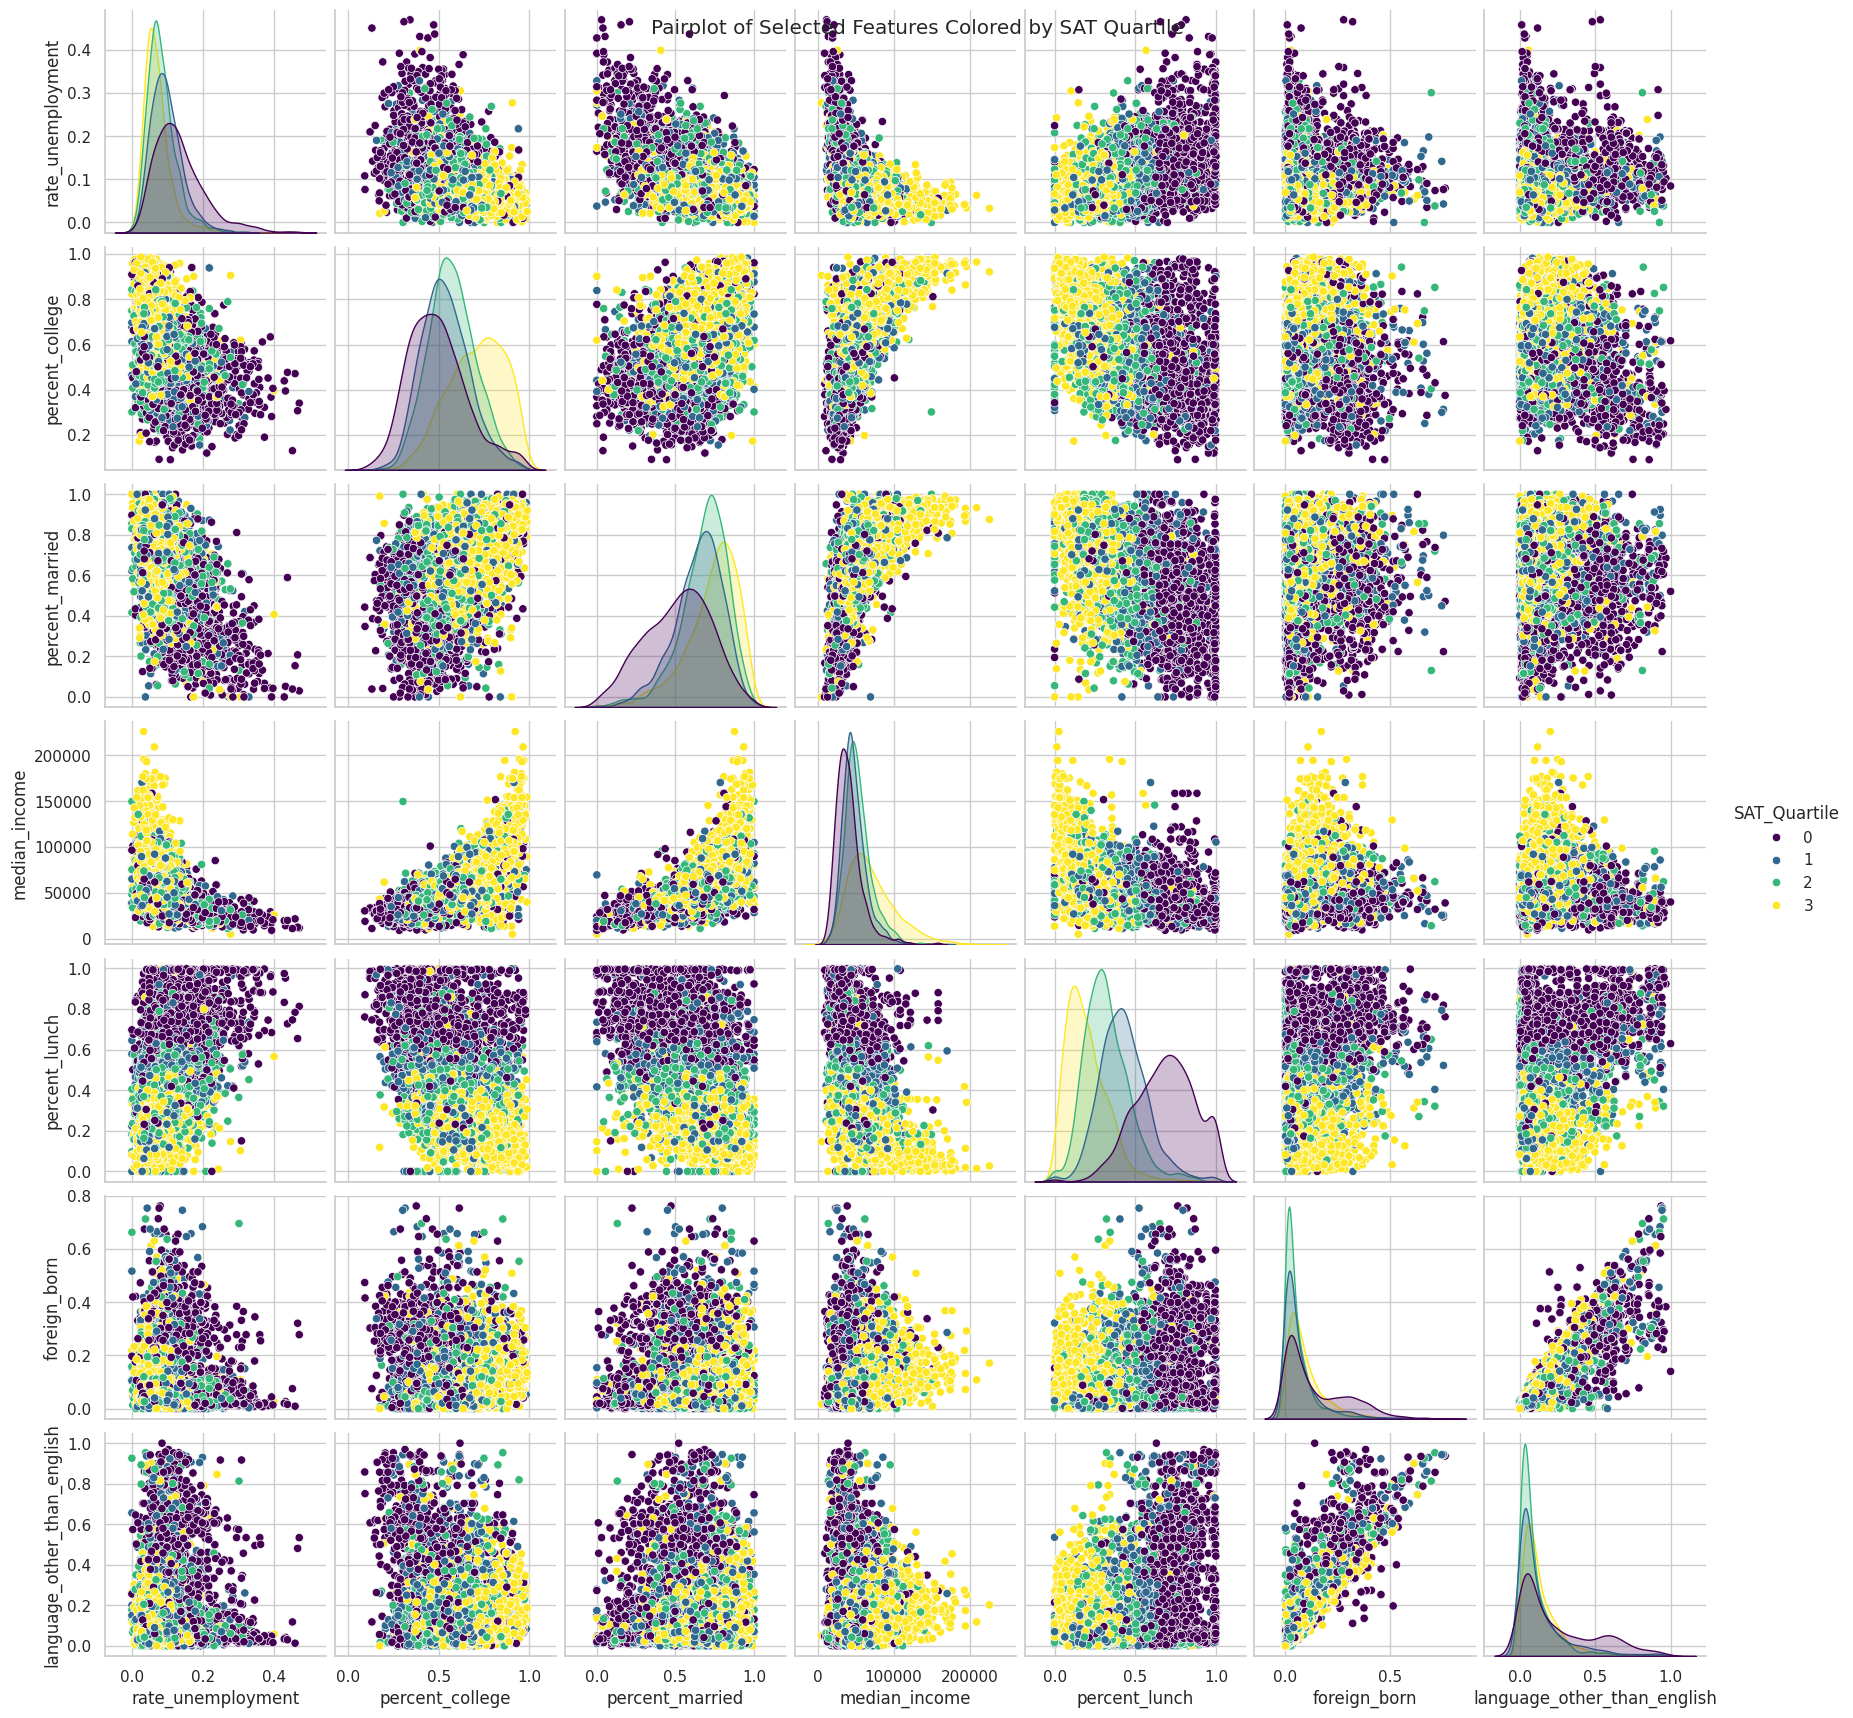

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Combine quartiles with the original DataFrame
df_with_quartiles = pd.concat([df, quartiles.rename('SAT_Quartile')], axis=1)

# Define the features for the pairplot
features = ['rate_unemployment', 'percent_college', 'percent_married',
            'median_income', 'percent_lunch',
            'foreign_born', 'language_other_than_english']

# Create pairplot colored by SAT quartile
sns.pairplot(df_with_quartiles, hue='SAT_Quartile', palette='viridis', vars=features)
plt.suptitle('Pairplot of Selected Features Colored by SAT Quartile')
plt.show()

This is a good look at how the quartiles are correlated with different features

##### $\rightarrow$ Now let's take a look at the pearson correlation coefficients between features and ACT score to see which ones look most important

In [ ]:
from scipy.stats import pearsonr

# Features to calculate correlation with average_act
features = ['rate_unemployment', 'percent_college', 'percent_married',
            'median_income', 'percent_lunch',
            'foreign_born', 'language_other_than_english']

# Calculate Pearson correlation coefficient for each feature
for feature in features:
    correlation, p_value = pearsonr(X_train[feature], y_train)
    print(f"{feature} {correlation}, p-value: {p_value}")

rate_unemployment -0.44604898708756885, p-value: 7.053250244731625e-280
percent_college 0.46102274419419964, p-value: 2.75893807586665e-301
percent_married 0.44963865186048224, p-value: 6.51030147000468e-285
median_income 0.46202108789476054, p-value: 9.440469933962965e-303
percent_lunch -0.7864097559163217, p-value: 0.0
foreign_born -0.18122462048837307, p-value: 9.68582674255133e-44
language_other_than_english -0.24115278252347447, p-value: 4.8571398200058116e-77


Most of these look correlated to some extent, with percent_lunch highly negatively correlated at -0.786.

Positiviley correlated:
- percent of adults with a college degree
- percent of children in marries couple family
- median household income

Negatively correlated:
- unemployment rate
- percent of students on subsidized or free lunch
- percentage of foreign born residents
- language other than english spoken at home


On the other hand, language_other_than_english and foreign_born aren't heavily correlated. We saw this in the previous 2 plots, with them decreasing from Q1 to Q3, then increasing in the highest quartile. For the purposes of a linear model they may not add much, but they could be captured with a regression tree.

## Regression Model

Let's use what we've learned about the features in our dataset to create a model predicting school ACT score

##### $\rightarrow$ Let's begin by finding the best combination of our features using best subset selection

In [ ]:
print(X_train.shape)

(5763, 13)


In [ ]:
features = ['rate_unemployment', 'percent_college', 'percent_married',
            'median_income', 'percent_lunch']

# Iterate over each combination of features
for combo in feature_combos:
    # Construct feature matrix based on current combination
    selected_features = [feat for feat, include in zip(features, combo) if include]

    # Exclude the case where all features are excluded
    if not all(feat == 0 for feat in combo):

        # Ensure that selected_features is not empty
        if selected_features:
            X_train_subset = X_train[selected_features]
            X_test_subset = X_test[selected_features]  # Add this line

            # Fit linear regression model to training data
            lr.fit(X_train_subset, y_train)

            # Predict on test data
            y_pred_test = lr.predict(X_test_subset)

            # Calculate R-squared and RMSE
            r2 = r2_score(y_test, y_pred_test)
            rmse = mean_squared_error(y_test, y_pred_test, squared=False)

            # Store results in dictionary
            results_dict[str(selected_features)] = {'R-squared': r2, 'RMSE': rmse}

# Print results
for feature_set, metrics in results_dict.items():
    print(f"Features: {feature_set}, R-squared: {metrics['R-squared']}, RMSE: {metrics['RMSE']}")

Features: ['language_other_than_english'], R-squared: 0.05534708123888865, RMSE: 2.3760618496590795
Features: ['foreign_born'], R-squared: 0.029359821550516196, RMSE: 2.4085226682407206
Features: ['foreign_born', 'language_other_than_english'], R-squared: 0.06058098996459915, RMSE: 2.3694703469908904
Features: ['percent_lunch'], R-squared: 0.6030609139545283, RMSE: 1.5402227666698036
Features: ['percent_lunch', 'language_other_than_english'], R-squared: 0.6015718950082984, RMSE: 1.5431089451612887
Features: ['percent_lunch', 'foreign_born'], R-squared: 0.6031111481532856, RMSE: 1.5401253029689557
Features: ['percent_lunch', 'foreign_born', 'language_other_than_english'], R-squared: 0.6025859676371674, RMSE: 1.5411439463502676
Features: ['median_income'], R-squared: 0.20622008251499857, RMSE: 2.1780691284490223
Features: ['median_income', 'language_other_than_english'], R-squared: 0.26307441652532304, RMSE: 2.098618141866648
Features: ['median_income', 'foreign_born'], R-squared: 0.2582

Find the best feature combination with the highest R-squared

In [ ]:
best_combination_r2 = max(results_dict, key=lambda k: results_dict[k]['R-squared'])

# extract R-squared for the best combination
best_r2 = results_dict[best_combination_r2]['R-squared']

# find the best feature combination with the lowest RMSE
best_combination_rmse = min(results_dict, key=lambda k: results_dict[k]['RMSE'])
# extract RMSE for the best combination
best_rmse = results_dict[best_combination_rmse]['RMSE']

print(best_combination_r2)
print(best_r2)
print(best_combination_rmse)
print(best_rmse)

['percent_college', 'percent_lunch']
0.6156764595269913
['percent_college', 'percent_lunch']
1.5155494077371006


##### $\rightarrow$ Apply to Linear regression model

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# best feature combination
best_features = ['percent_college', 'percent_lunch']

# extract the corresponding feature matrix for both train and test sets
X_train_best = X_train[best_features]
X_test_best = X_test[best_features]

# initialize and fit the linear regression model
lr = LinearRegression()
lr.fit(X_train_best, y_train)

# make predictions on the training set
y_train_pred = lr.predict(X_train_best)

# evaluate the model's performance on the training set
train_rmse = mean_squared_error(y_train, y_train_pred, squared=False)
train_r2 = r2_score(y_train, y_train_pred)

# make predictions on the test set
y_test_pred = lr.predict(X_test_best)

# evaluate the model's performance on the test set
test_rmse = mean_squared_error(y_test, y_test_pred, squared=False)
test_r2 = r2_score(y_test, y_test_pred)

print("Training set - RMSE: {:.4f}, R-squared: {:.4f}".format(train_rmse, train_r2))
print("Test set - RMSE: {:.4f}, R-squared: {:.4f}".format(test_rmse, test_r2))

Training set - RMSE: 1.5333, R-squared: 0.6310
Test set - RMSE: 1.5155, R-squared: 0.6157


Plotting the training and test set

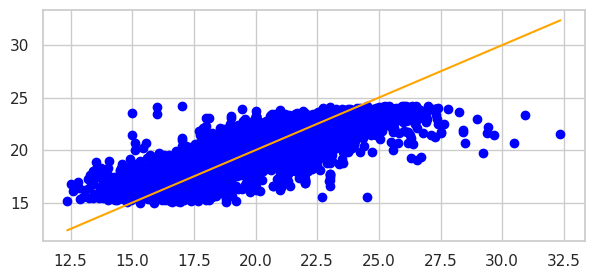

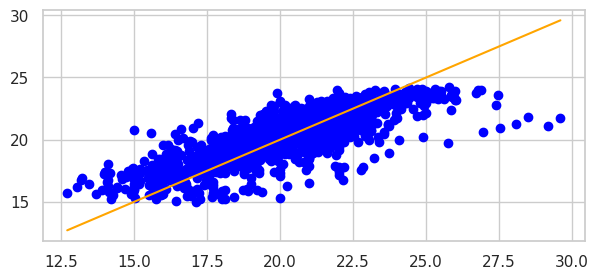

In [ ]:
# plotting the training set
plt.figure(figsize=(7, 3))
plt.scatter(y_train, y_train_pred, color='blue', label='Actual vs Predicted (Training)')
plt.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], color='orange')
plt.show()

# plotting the test set
plt.figure(figsize=(7, 3))
plt.scatter(y_test, y_test_pred, color='blue', label='Actual vs Predicted (Test)')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='orange')
plt.show()

Interesting results, not a lot of overfitting - probably because of there only being 2 variables

##### $\rightarrow$ Regression Tree

We'll use GridSearchCV to identify the optimal combination of parameters (no. of trees, sample split) for the regression tree

In [ ]:
from sklearn.model_selection import GridSearchCV

selected_features = ['rate_unemployment', 'percent_college', 'percent_married',
                     'median_income', 'percent_lunch', 'foreign_born',
                     'language_other_than_english']

# Filter the feature matrix X_train and X_test to include only the selected features
X_train_selected = X_train[selected_features]
X_test_selected = X_test[selected_features]

# Defining the search space for hyperparameters
param_grid = {
    'n_estimators': [8, 16, 32, 64, 128],
    'min_samples_split': [2, 4, 8]
}

# Initialize the Random Forest regressor
regressor = RandomForestRegressor()

# Perform grid search using cross-validation
grid_search = GridSearchCV(estimator=regressor, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error')

# Train the model on the training data
grid_search.fit(X_train_selected, y_train)

grid_search.best_estimator_

RandomForestRegressor(min_samples_split=4, n_estimators=128)

Applying best estimator to the model

In [ ]:
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# selecting only the specified variables
selected_features = ['rate_unemployment', 'percent_college', 'percent_married',
                     'median_income', 'percent_lunch', 'foreign_born',
                     'language_other_than_english']

# filter the feature matrix X_train and X_test to include only the selected features
X_train_selected = X_train[selected_features]
X_test_selected = X_test[selected_features]

# get the best estimator from the grid search
best_regressor = grid_search.best_estimator_

# make predictions on the training and test data using the best estimator
y_train_pred = best_regressor.predict(X_train_selected)
y_test_pred = best_regressor.predict(X_test_selected)

# evaluate the model
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))

train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)

print("Best parameters found by grid search:", grid_search.best_params_)
print("Training RMSE:", train_rmse)
print("Test RMSE:", test_rmse)
print("Training R-squared:", train_r2)
print("Test R-squared:", test_r2)

Best parameters found by grid search: {'min_samples_split': 4, 'n_estimators': 128}
Training RMSE: 0.5901181204938648
Test RMSE: 1.3997773931159894
Training R-squared: 0.9453393378144265
Test R-squared: 0.6721503391991792


Some overfitting, but improved from our linear regression model.

Bar plot using feature importances from GridSearchCV

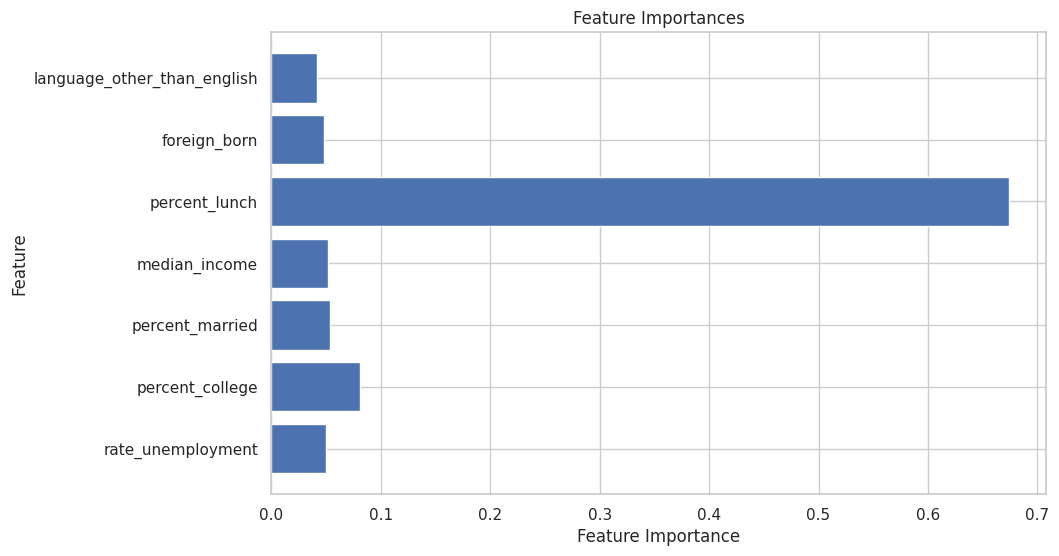

In [ ]:
feature_importances = best_regressor.feature_importances_

# Create a bar plot to visualize feature importances
plt.figure(figsize=(10, 6))
plt.barh(selected_features, feature_importances)
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Feature Importances')
plt.show()

Well, percent_lunch shows it's value once again. Good to note that language_other_than_english and foreign_born do contrubute to the model.

## Conclusion

My primary focus of this analysis was to discern what socioeconomic factors have/don't have a correlation with school ACT score, and using that seeing how well we're able to predict ACT score.

After doing exploratory analysis by splitting the data into quartiles it became clear that the majority of these variables were correlated with ACT score, some negatively some positively. In looking at the linear correlations of each variable it became clear that percentage of free and reduced lunch was the most powerful predictor. Most other variables also pointed towards being correlated with ACT as well, with the exception of the additional variables (foreign born and other language spoken). But this didn't necessarily mean they weren't useful, in looking at the quartiles I observed that the additional variables followed an unusual distribution where they were decreasing as ACT became higher, then increasing again in the highest quartile. They werent going to be useful in regression, but could contribute to a non-linear model.


This showed in the linear regression and regression tree modeling. Free and reduced lunch & percent of adults with a college degree were found to be the best predictors in best subset selection. In the regression tree, free and reduced lunch was once again the strongest predictor, and the additional variables were able to add a similar value to the model as the others.


The question of how good a linear model is depends on numerous factors. Our best model explainins 67.2% of the variance in ACT score, a complex idea influenced by an almost unlimited number of factors, with a limited scope of variables. So to answer the question, yes, ACT scores can be predicted from socioeconomic factors.